# HLS Quick Start - Single Area Download

Download harmonized Landsat-Sentinel (HLS) imagery for a single area.

**HLS Benefits:**
- Combined Landsat 8/9 and Sentinel-2 data
- ~3 day revisit time (vs 5-16 days individually)
- Consistent 30m resolution
- Radiometrically harmonized

Author: Peter Kongstad

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box, Point

from sat_data_acquisition import SatDataClient, ProcessingParams, SaveParams, configure_logging
from sat_data_acquisition.processing import save_data
from sat_data_acquisition.config.settings import SatDataSettings

In [3]:
# Configure logging
configure_logging(verbose=False)

## Define Area of Interest

Create a bounding box around Copenhagen, Denmark.

In [4]:
# Define area as bounding box (rectangular shape)
copenhagen_center = Point(12.5683, 55.6761)  # lon, lat
buffer = 0.024  # ~5 km radius

geometry = box(
    copenhagen_center.x - buffer,
    copenhagen_center.y - buffer,
    copenhagen_center.x + buffer,
    copenhagen_center.y + buffer
)

print(f"Area bounds: {geometry.bounds}")
print(f"Approximate area: {(buffer * 111 * 2)**2:.1f} km²")

Area bounds: (12.544300000000002, 55.6521, 12.5923, 55.7001)
Approximate area: 28.4 km²


## Download Both HLS Sources

Download imagery from both HLS_SENTINEL and HLS_LANDSAT for comparison.

In [5]:
# Initialize client
client = SatDataClient()
settings = SatDataSettings()

# Download HLS Sentinel
params_sentinel = ProcessingParams(
    satellite='HLS_SENTINEL',
    bands=['B04', 'B03', 'B02'],  # RGB
    search_method='geometry',
    start_date='2024-06-01',
    end_date='2024-08-31',
    cloud_coverage=15,
    groupby='solar_day',
)

dataset_sentinel = client.search_and_create_image(
    geometry=geometry,
    processing_params=params_sentinel,
    area_name='copenhagen'
)

print(f"[OK] HLS Sentinel: {len(dataset_sentinel.time)} images")

# Download HLS Landsat
params_landsat = ProcessingParams(
    satellite='HLS_LANDSAT',
    bands=['B04', 'B03', 'B02'],  # RGB
    search_method='geometry',
    start_date='2024-06-01',
    end_date='2024-08-31',
    cloud_coverage=15,
    groupby='solar_day',
)

dataset_landsat = client.search_and_create_image(
    geometry=geometry,
    processing_params=params_landsat,
    area_name='copenhagen'
)

print(f"[OK] HLS Landsat: {len(dataset_landsat.time)} images")

[OK] HLS Sentinel: 30 images
[OK] HLS Landsat: 17 images


## Compare HLS Sentinel vs HLS Landsat

Display the most recent image from each source side-by-side.

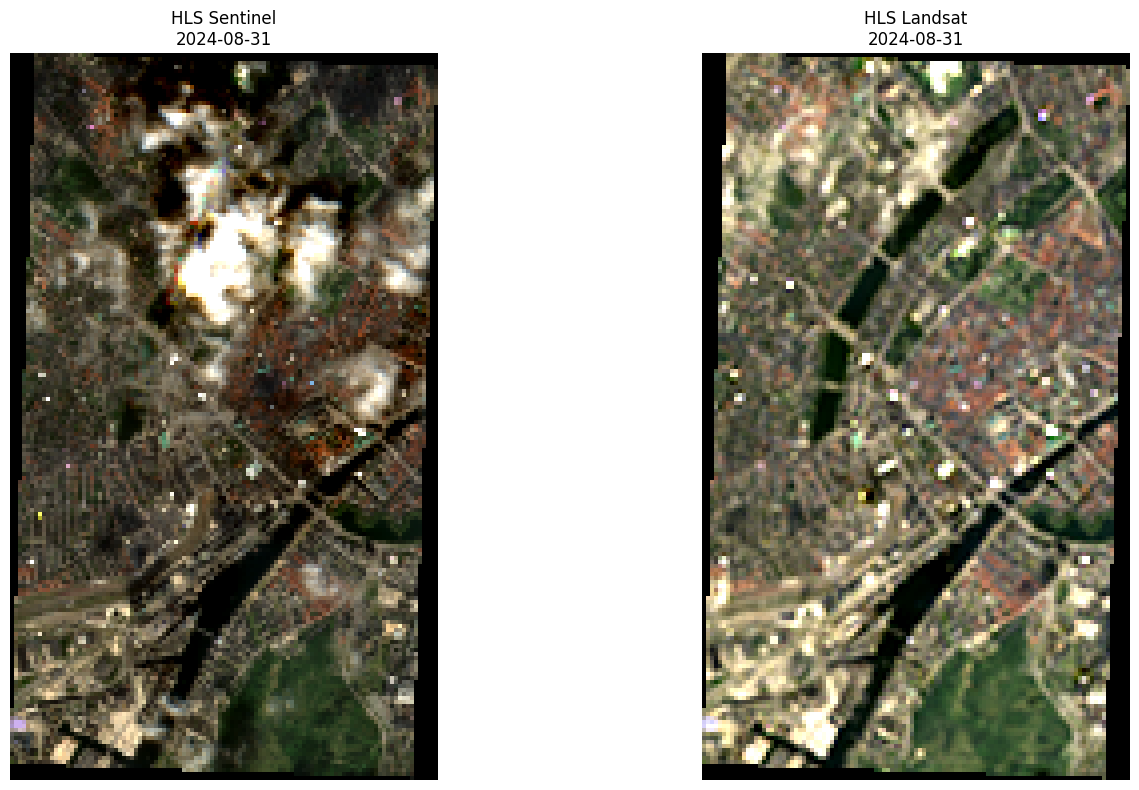


Comparison saved as: hls_comparison.png


In [6]:
def process_rgb_for_display(image_slice, gamma=0.9):
    """
    Process RGB bands for display with percentile stretching.
    
    Args:
        image_slice: xarray Dataset with B04, B03, B02 bands
        gamma: Gamma correction value (default 0.9)
        
    Returns:
        RGB array (H, W, 3) with values in [0, 1]
    """
    # Stack RGB bands (HLS uses B04=red, B03=green, B02=blue)
    rgb = np.dstack([
        image_slice['B04'].values,
        image_slice['B03'].values,
        image_slice['B02'].values
    ])
    
    # Get valid pixels
    valid_pixels = rgb[rgb > 0]
    
    if len(valid_pixels) == 0:
        return np.zeros_like(rgb)
    
    # Percentile stretching (2nd-98th percentile)
    p2, p98 = np.percentile(valid_pixels, [2, 98])
    rgb_stretched = np.clip((rgb - p2) / (p98 - p2), 0, 1)
    
    # Gamma correction
    rgb_corrected = np.power(rgb_stretched, gamma)
    
    return rgb_corrected


# Compare both sources side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# HLS Sentinel
if len(dataset_sentinel.time) > 0:
    latest_image = dataset_sentinel.sel(time=dataset_sentinel.time.values[-1])
    date_str = str(dataset_sentinel.time.values[-1])[:10]
    rgb = process_rgb_for_display(latest_image)
    
    axes[0].imshow(rgb)
    axes[0].set_title(f'HLS Sentinel\n{date_str}', fontsize=12)
    axes[0].axis('off')
else:
    axes[0].text(0.5, 0.5, 'No HLS Sentinel images', ha='center', va='center', 
                transform=axes[0].transAxes)
    axes[0].axis('off')

# HLS Landsat
if len(dataset_landsat.time) > 0:
    latest_image = dataset_landsat.sel(time=dataset_landsat.time.values[-1])
    date_str = str(dataset_landsat.time.values[-1])[:10]
    rgb = process_rgb_for_display(latest_image)
    
    axes[1].imshow(rgb)
    axes[1].set_title(f'HLS Landsat\n{date_str}', fontsize=12)
    axes[1].axis('off')
else:
    axes[1].text(0.5, 0.5, 'No HLS Landsat images', ha='center', va='center', 
                transform=axes[1].transAxes)
    axes[1].axis('off')

plt.tight_layout()
plt.savefig('hls_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nComparison saved as: hls_comparison.png")

## Save to GeoTIFF (Optional)

Save imagery from both sources to disk for further analysis.

In [7]:
# Configure save parameters
save_params = SaveParams(
    output_path='../../data',
    save_to_local=True,
    save_as_geotiff=True,
)

# Save HLS Sentinel images
if len(dataset_sentinel.time) > 0:
    print("Saving HLS Sentinel images...")
    for time_val in dataset_sentinel.time.values:
        image_slice = dataset_sentinel.sel(time=time_val)
        date_str = str(time_val)[:10]
        
        save_data(
            image=image_slice,
            identifier="copenhagen",
            datetime=date_str,
            satellite=params_sentinel.satellite,
            provider="MPC",
            save_params=save_params,
            band="TCI",
        )
    print(f"  ✓ Saved {len(dataset_sentinel.time)} HLS Sentinel images")

# Save HLS Landsat images
if len(dataset_landsat.time) > 0:
    print("\nSaving HLS Landsat images...")
    for time_val in dataset_landsat.time.values:
        image_slice = dataset_landsat.sel(time=time_val)
        date_str = str(time_val)[:10]
        
        save_data(
            image=image_slice,
            identifier="copenhagen",
            datetime=date_str,
            satellite=params_landsat.satellite,
            provider="MPC",
            save_params=save_params,
            band="TCI",
        )
    print(f"  ✓ Saved {len(dataset_landsat.time)} HLS Landsat images")

print("\n✓ All images saved to: ../../data/")

Saving HLS Sentinel images...
  ✓ Saved 30 HLS Sentinel images

Saving HLS Landsat images...
  ✓ Saved 17 HLS Landsat images

✓ All images saved to: ../../data/


## Next Steps

- Try [multi_image_download.ipynb](multi_image_download.ipynb) for time series analysis
- Combine HLS_LANDSAT and HLS_SENTINEL for ~3 day revisit time
- Use QA band (B12) for cloud masking
- Explore SWIR bands (B06, B07) for additional analysis

## HLS Key Advantages

**Higher Temporal Frequency:**
- HLS Sentinel: ~5 days revisit
- HLS Landsat: ~16 days revisit  
- Combined: ~3 days effective revisit time

**Harmonized Data:**
- Consistent radiometry between sensors
- Same band naming convention (B01-B12)
- Same 30m resolution
- Cross-calibrated for seamless integration

**Use Cases:**
- Agricultural monitoring requiring frequent observations
- Rapid change detection
- Gap-filling in cloud-prone regions
- Time series analysis with consistent data